In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 80

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [2]:
# Exploring Quantitative versus Qualitative features

def quantitativeVariables(frame, id_col, target_col):
    quantitative = [f for f in frame.columns if frame.dtypes[f] != 'object']
    quantitative.remove(target_col)
    quantitative.remove(id_col)
    return quantitative

def qualitativeVariables(frame):
    qualitative = [f for f in frame.columns if frame.dtypes[f] == 'object']
    return qualitative

def quantVersusQualEDA(frame):
    quantitative = quantitativeVariables(train, "Id", "SalePrice")
    qualitative = qualitativeVariables(train)
    
    print("There are ", frame.shape[0], " data samples and ", frame.shape[1], " features including ID and SalePrice")
    print("There are ", len(quantitative), " quantitative features", "\n")
    print("Quantitative: ", quantitative, "\n")
    print("There are ", len(qualitative), " qualitative features", "\n")
    print("Qualitative: ", qualitative, "\n")
    
quantVersusQualEDA(train)

There are  1460  data samples and  81  features including ID and SalePrice
There are  36  quantitative features 

Quantitative:  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'] 

There are  43  qualitative features 

Qualitative:  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',

In [3]:
# Some quantitative features, like MSSubClass and MoSold, are actually qualitative features

def quantToQual(frame):
    MSSubClassVals = frame['MSSubClass'].unique()
    MSSubClassDict = {}
    for val in MSSubClassVals:
        MSSubClassDict[val] = 'SC' + str(val)
    frame = frame.replace({'MSSubClass' : MSSubClassDict, 
                       'MoSold' : {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun',
                                   7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}})
    return frame

train = quantToQual(train)
quantVersusQualEDA(train)

There are  1460  data samples and  81  features including ID and SalePrice
There are  34  quantitative features 

Quantitative:  ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold'] 

There are  45  qualitative features 

Qualitative:  ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinT

In [4]:
def qualMostCommon(frame):
    qualitative = qualitativeVariables(frame)
    qualMostCommonDict = {}
    for f in qualitative:
        qualMostCommonDict[f] = frame[f].value_counts().idxmax()
    return qualMostCommonDict

qualMostCommonDict = qualMostCommon(train)
print(qualMostCommonDict)

{'MSSubClass': 'SC20', 'MSZoning': 'RL', 'Street': 'Pave', 'Alley': 'Grvl', 'LotShape': 'Reg', 'LandContour': 'Lvl', 'Utilities': 'AllPub', 'LotConfig': 'Inside', 'LandSlope': 'Gtl', 'Neighborhood': 'NAmes', 'Condition1': 'Norm', 'Condition2': 'Norm', 'BldgType': '1Fam', 'HouseStyle': '1Story', 'RoofStyle': 'Gable', 'RoofMatl': 'CompShg', 'Exterior1st': 'VinylSd', 'Exterior2nd': 'VinylSd', 'MasVnrType': 'None', 'ExterQual': 'TA', 'ExterCond': 'TA', 'Foundation': 'PConc', 'BsmtQual': 'TA', 'BsmtCond': 'TA', 'BsmtExposure': 'No', 'BsmtFinType1': 'Unf', 'BsmtFinType2': 'Unf', 'Heating': 'GasA', 'HeatingQC': 'Ex', 'CentralAir': 'Y', 'Electrical': 'SBrkr', 'KitchenQual': 'TA', 'Functional': 'Typ', 'FireplaceQu': 'Gd', 'GarageType': 'Attchd', 'GarageFinish': 'Unf', 'GarageQual': 'TA', 'GarageCond': 'TA', 'PavedDrive': 'Y', 'PoolQC': 'Gd', 'Fence': 'MnPrv', 'MiscFeature': 'Shed', 'MoSold': 'Jun', 'SaleType': 'WD', 'SaleCondition': 'Normal'}


In [5]:
def quantMedian(frame):
    quantitative = quantitativeVariables(frame,'Id','SalePrice')
    quantMedianDict = {}
    for f in quantitative:
        quantMedianDict[f] = frame[f].median()
    return quantMedianDict

quantMedianDict = quantMedian(train)
print(quantMedianDict)

{'LotFrontage': 69.0, 'LotArea': 9478.5, 'OverallQual': 6.0, 'OverallCond': 5.0, 'YearBuilt': 1973.0, 'YearRemodAdd': 1994.0, 'MasVnrArea': 0.0, 'BsmtFinSF1': 383.5, 'BsmtFinSF2': 0.0, 'BsmtUnfSF': 477.5, 'TotalBsmtSF': 991.5, '1stFlrSF': 1087.0, '2ndFlrSF': 0.0, 'LowQualFinSF': 0.0, 'GrLivArea': 1464.0, 'BsmtFullBath': 0.0, 'BsmtHalfBath': 0.0, 'FullBath': 2.0, 'HalfBath': 0.0, 'BedroomAbvGr': 3.0, 'KitchenAbvGr': 1.0, 'TotRmsAbvGrd': 6.0, 'Fireplaces': 1.0, 'GarageYrBlt': 1980.0, 'GarageCars': 2.0, 'GarageArea': 480.0, 'WoodDeckSF': 0.0, 'OpenPorchSF': 25.0, 'EnclosedPorch': 0.0, '3SsnPorch': 0.0, 'ScreenPorch': 0.0, 'PoolArea': 0.0, 'MiscVal': 0.0, 'YrSold': 2008.0}


In [6]:
# Check for duplicates

def duplicateCheck(frame):
    duplicated = frame.duplicated().sum()
    print(duplicated)
    
duplicateCheck(train)

0


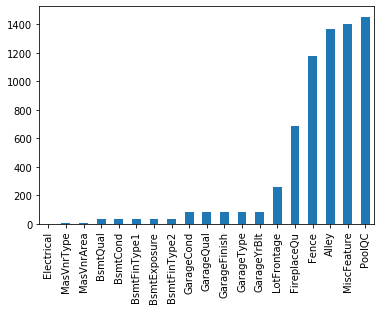

In [7]:
# Check for missing values

def missingCheck(frame):
    missing = frame.isnull().sum()
    missing = missing[missing>0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
    return missing
    
missingTrain = missingCheck(train)

In [8]:
# Columns where NA is being misread as NaN

NACols = missingTrain.index.tolist()
NACols.remove('Electrical')
NACols.remove('MasVnrType')
NACols.remove('MasVnrArea')
NACols.remove('GarageYrBlt')
NACols.remove('LotFrontage')
print(NACols)

['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtExposure', 'BsmtFinType2', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']


In [9]:
# Explicitly fill these columns with NA

for col in NACols:
    train[col] = train[col].fillna('NA')
    print(col, train[col].isnull().sum())

BsmtQual 0
BsmtCond 0
BsmtFinType1 0
BsmtExposure 0
BsmtFinType2 0
GarageCond 0
GarageQual 0
GarageFinish 0
GarageType 0
FireplaceQu 0
Fence 0
Alley 0
MiscFeature 0
PoolQC 0


In [10]:
# Fill in missing values of GarageYrBlt with YearBuilt

train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['YearBuilt'])

In [11]:
# Fill in LotFrontage with the square root of LotArea
sqrtLotArea = np.floor(train['LotArea']**(1/2))
train['LotFrontage'] = train['LotFrontage'].fillna(sqrtLotArea)
train.head(n=10)

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1       SC60       RL         65.0     8450   Pave    NA      Reg   
1   2       SC20       RL         80.0     9600   Pave    NA      Reg   
2   3       SC60       RL         68.0    11250   Pave    NA      IR1   
3   4       SC70       RL         60.0     9550   Pave    NA      IR1   
4   5       SC60       RL         84.0    14260   Pave    NA      IR1   
5   6       SC50       RL         85.0    14115   Pave    NA      IR1   
6   7       SC20       RL         75.0    10084   Pave    NA      Reg   
7   8       SC60       RL        101.0    10382   Pave    NA      IR1   
8   9       SC50       RM         51.0     6120   Pave    NA      Reg   
9  10      SC190       RL         50.0     7420   Pave    NA      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
5         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
6         Lvl    AllPub    Inside       Gtl      Somerst       Norm   
7         Lvl    AllPub    Corner       Gtl       NWAmes       PosN   
8         Lvl    AllPub    Inside       Gtl      OldTown     Artery   
9         Lvl    AllPub    Corner       Gtl      BrkSide     Artery   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   
5       Norm     1Fam     1.5Fin            5            5       1993   
6       Norm     1Fam     1Story            8            5       2004   
7       Norm     1Fam     2Story            7            6       1973   
8       Norm     1Fam     1.5Fin            7            5       1931   
9     Artery   2fmCon     1.5Unf            5            6       1939   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
5          1995     Gable  CompShg     VinylSd     VinylSd       None   
6          2005     Gable  CompShg     VinylSd     VinylSd      Stone   
7          1973     Gable  CompShg     HdBoard     HdBoard      Stone   
8          1950     Gable  CompShg     BrkFace     Wd Shng       None   
9          1950     Gable  CompShg     MetalSd     MetalSd       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   
5         0.0        TA        TA       Wood       Gd       TA           No   
6       186.0        Gd        TA      PConc       Ex       TA           Av   
7       240.0        TA        TA     CBlock       Gd       TA           Mn   
8         0.0        TA        TA     BrkTil       TA       TA           No   
9         0.0      

In [12]:
# Fill in Missing Qualitative Variables with the most common type
for f in ['Electrical', 'MasVnrType']:
    train[f] = train[f].fillna(qualMostCommonDict[f])
    print(f, train[f].isnull().sum())

Electrical 0
MasVnrType 0


In [13]:
# Fill in Missing Quantitative Variables with the median
train['MasVnrArea'] = train['MasVnrArea'].fillna(quantMedianDict['MasVnrArea'])
print(train['MasVnrArea'].isnull().sum())

0


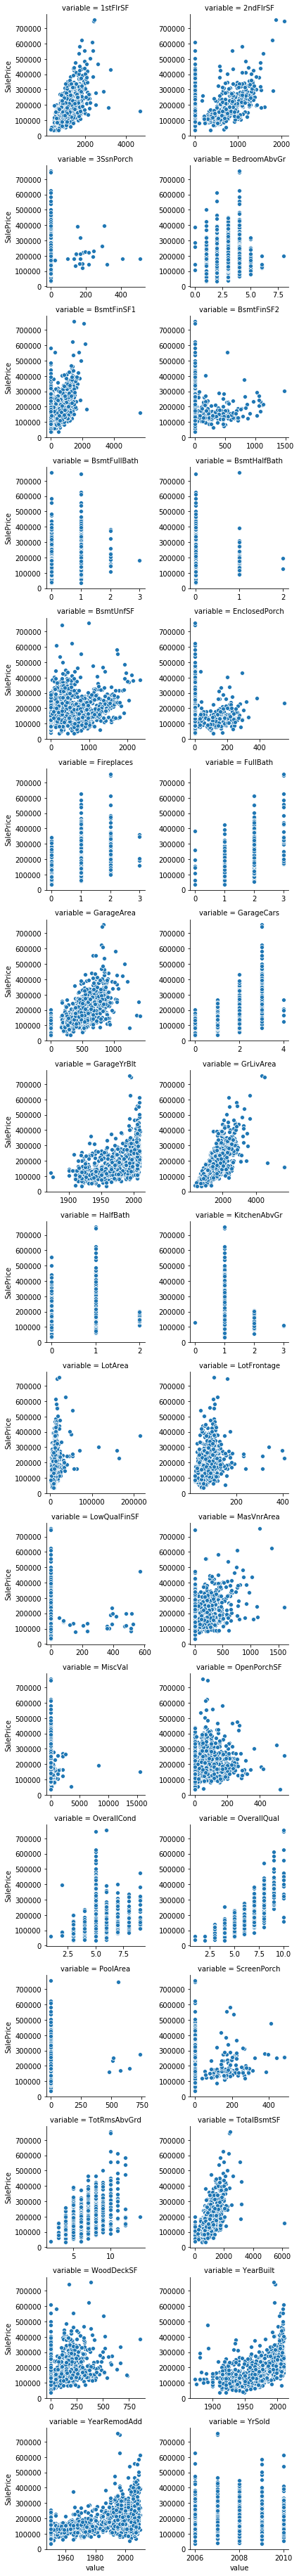

In [14]:
# Check for outliers using scatterplots

def outlierScatterplotCheck(frame, id_var):
    quantitative = quantitativeVariables(frame, 'Id', 'SalePrice')
    
    f = pd.melt(frame, id_vars=[id_var], value_vars=quantitative)
    f = f.sort_values('variable')
    g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey = False )
    g = g.map(sns.scatterplot, "value", id_var)
    
outlierScatterplotCheck(train, 'SalePrice')

In [15]:
# Find outliers using the median absolute deviation method

def mad_method(df, quantCols):
    df = df[quantCols]
    med = np.median(df, axis=0)
    mad = np.abs(stats.median_absolute_deviation(df))
    threshold = 5
    outlierDict = {}
    for i in range(len(quantCols)):
        outliers = []
        for j,v in enumerate(df.loc[:,quantCols[i]]):
            t = ( v - med[i] ) / mad[i]
            if t > threshold:
                outliers.append(j)
        outlierDict[quantCols[i]] = outliers
    return outlierDict

outlierCols = ['1stFlrSF', 'BsmtFinSF1','GrLivArea', 'TotalBsmtSF']
outlierDict = mad_method(train, outlierCols)
print(outlierDict)

{'1stFlrSF': [496, 523, 1024, 1298], 'BsmtFinSF1': [1298], 'GrLivArea': [523, 691, 1182, 1298], 'TotalBsmtSF': [332, 440, 496, 523, 1298]}


In [16]:
# Inspect the outliers

def inspectOutliers(outlierDict):
    bigList = []
    for outlierlist in outlierDict.values():
        bigList = bigList + outlierlist
    bigSet = list(set(bigList))
    bigSet.sort()
    return bigSet

outliers = inspectOutliers(outlierDict)
train.iloc[outliers][outlierCols + ['SalePrice']]

1stFlrSF  BsmtFinSF1  GrLivArea  TotalBsmtSF  SalePrice
332       1629        1124       1629         3206     284000
440       2402        1767       2402         3094     555000
496       3228        1231       3228         3200     430000
523       3138        2260       4676         3138     184750
691       2444        1455       4316         2444     755000
1024      2898        1165       2898         1565     287000
1182      2411        2096       4476         2396     745000
1298      4692        5644       5642         6110     160000

In [17]:
# Drop Outliers

train = train.drop([523, 1298])

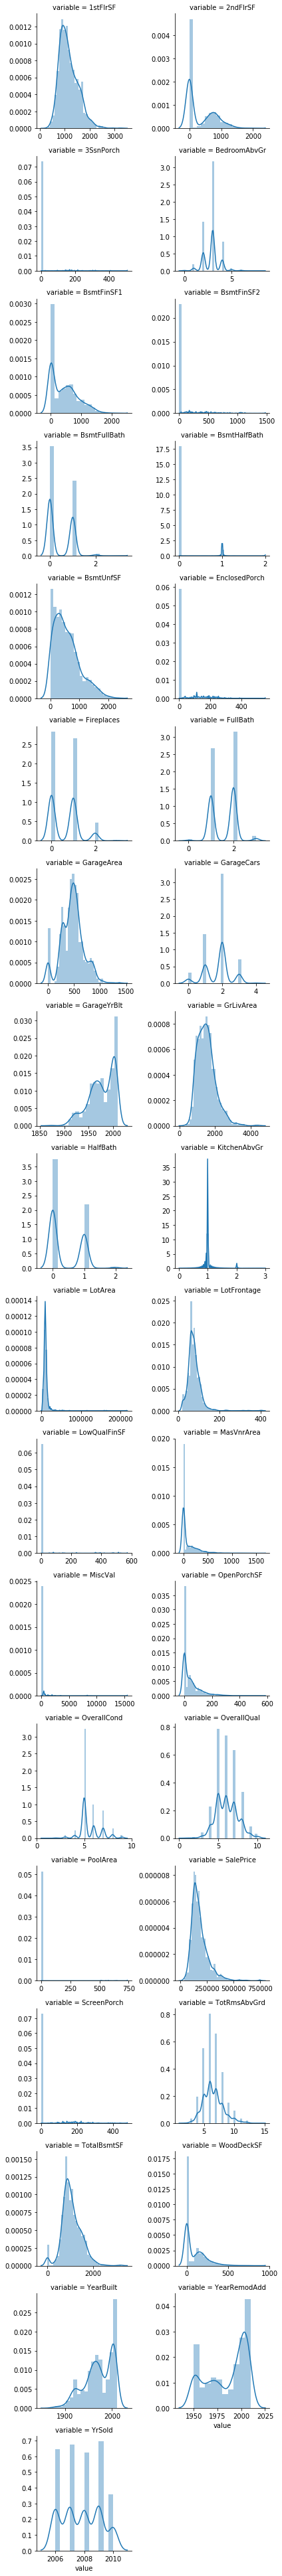

In [18]:
# Plot the distributions of all the quantitative variables including SalePrice

def quantVarDistPlot(frame):
    quantitative = quantitativeVariables(frame, 'Id', 'SalePrice') + ['SalePrice']
    
    f = pd.melt(frame, value_vars=quantitative)
    f=f.sort_values('variable')
    g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex = False, sharey = False )
    g = g.map(sns.distplot, "value")
    
quantVarDistPlot(train)

In [19]:
# Order the categories of each of the qualitative features by the median of SalePrice for that category.

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmedian'] = frame[[feature, 'SalePrice']].groupby(feature).median()['SalePrice']
    ordering = ordering.sort_values('spmedian')
    ordering['ordering'] = range(1,ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    return(ordering)

def featureOrdering(frame):
    featureOrdering = {}
    qualitative = qualitativeVariables(frame)
    for feature in qualitative:
        ordering = encode(frame,feature)
        featureOrdering[feature] = ordering
    return featureOrdering
    
featureOrdering = featureOrdering(train)

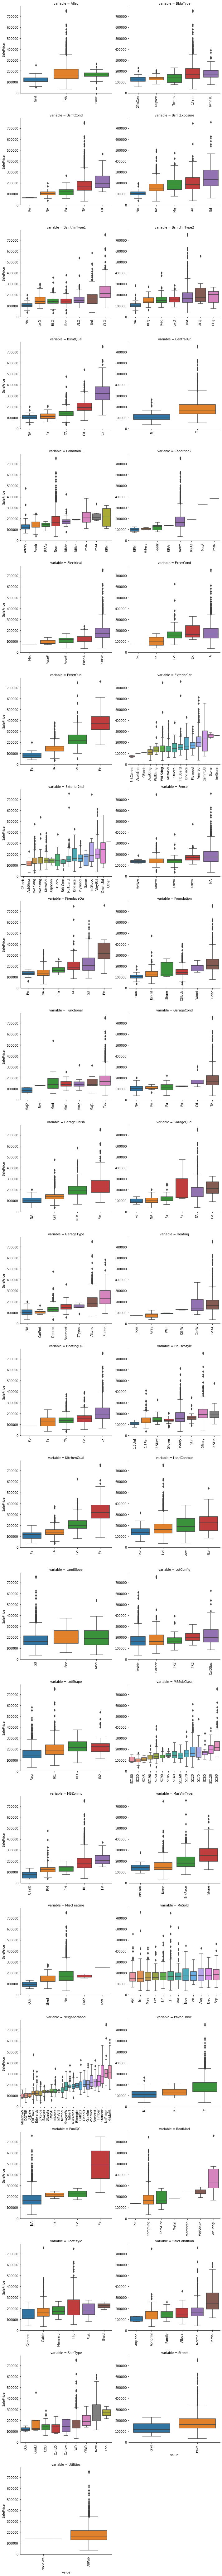

In [20]:
# Make boxplot to check the distribution of SalePrice for each of the different categories
# of the qualitative variables. 

# Remember that a box plot shows minimum, maximum, median, first quartile, and third 
# quartile. If a qualitiative feature is predictive, then the boxes corresponding to 
# different categories should be at different heights -- like neighborhood.

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

def qualBoxPlot(frame, id_var, featureOrdering):
    qualitative = qualitativeVariables(frame)
    f = pd.melt(frame, id_vars=[id_var], value_vars=qualitative)
    f['ordering'] = f.apply(lambda row: featureOrdering[row['variable']][row['value']], axis=1)
    f=f.sort_values(['variable', 'ordering'])
    
    g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex = False, sharey = False, height=5)
    g = g.map(boxplot, "value", id_var)
    
qualBoxPlot(train, 'SalePrice', featureOrdering)

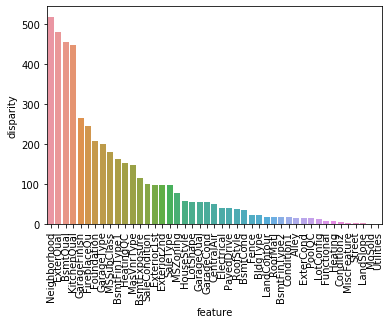

In [21]:
# For each feature, ANOVA tests the hypothesis that the class means are equal. 
# The output of ANOVA is the measure f of an F-statistic and a p-value.
#
# The p-value is the probability that the F-statistic would exceed the observed
# value f if the null hypothesis is true. The higher the p value, the more likely
# that the class means are equal.
#
# This is why we plot log of the inverse p-values. The closer the p-value is to 1, 
# more likely the null hypothesis that the class means are equal, the closer the 
# log of the inverse p-value is to zero. On the other hand, the closer the p-value
# is to 0, the less likely the null hypothesis that the class means are equal,
# the larger the log of the inverse p-value is.
#
# The features with the larger log of inverse p values are the ones where different
# classes have the most effect on the sale price.

def anova(frame):
    anv = pd.DataFrame()
    qualitative = qualitativeVariables(frame)
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s=frame[frame[c]==cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')
        
def anovaDisparity(frame):
    a=anova(frame)
    a['disparity'] = np.log(1./a['pval'].values)
    sns.barplot(data=a, x='feature', y='disparity')
    x=plt.xticks(rotation=90)
    
anovaDisparity(train)    

In [22]:
# Encode qualitative variables

def qualitativeEncode(frame):
    qualitative = qualitativeVariables(frame)
    for feature in qualitative:
        frame[feature + "_E"] = frame.apply(
            lambda row: featureOrdering[feature][row[feature]], axis=1)
    return frame    

trainWithQualE = train.copy()
trainWithQualE = qualitativeEncode(trainWithQualE)
trainWithQualE.head()    

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1       SC60       RL         65.0     8450   Pave    NA      Reg   
1   2       SC20       RL         80.0     9600   Pave    NA      Reg   
2   3       SC60       RL         68.0    11250   Pave    NA      IR1   
3   4       SC70       RL         60.0     9550   Pave    NA      IR1   
4   5       SC60       RL         84.0    14260   Pave    NA      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating  ... LandContour_E Utilities_E LotConfig_E  LandSlope_E  \
0    GasA  ...             2           2           1            1   
1    GasA  ...             2           2           3            1   
2    GasA  ...             2           2           1            1   
3    GasA  ...             2           2           2            1   
4    GasA  ...             2           2           3            1   

   Neighborhood_E  Condition1_E  Condition2_E  BldgType_E  HouseStyle_E  \
0              17             4             5           4             7   
1              20             2             5           4             5   
2              17             4             5           4             7   
3              19             4             5           4             7   
4              24             4             5           4             7   

   RoofStyle_E  RoofMatl_E  Exterior1st_E  Exterior2nd_E MasVnrType_E  \
0            2           2             12             14            3   
1            2           2              7              5            2   
2            2           2             12             14            3   
3            2           2              6              4            2   
4            2           2             12             14            3   

   E

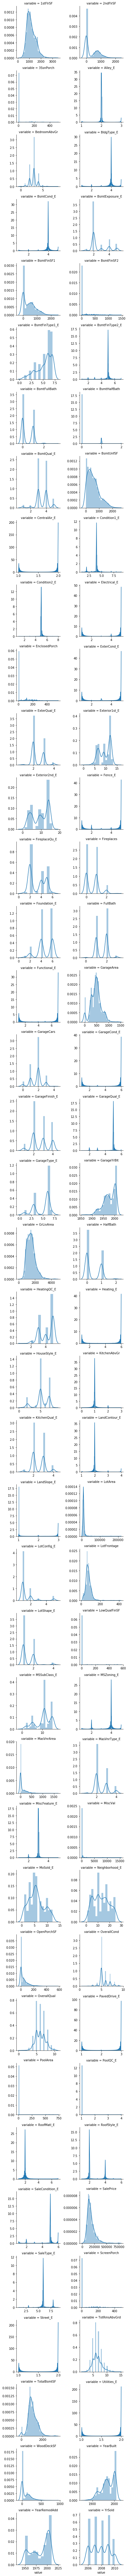

In [23]:
# Plot distributions of all the variables including the qualitative-encoded ones

quantVarDistPlot(trainWithQualE)

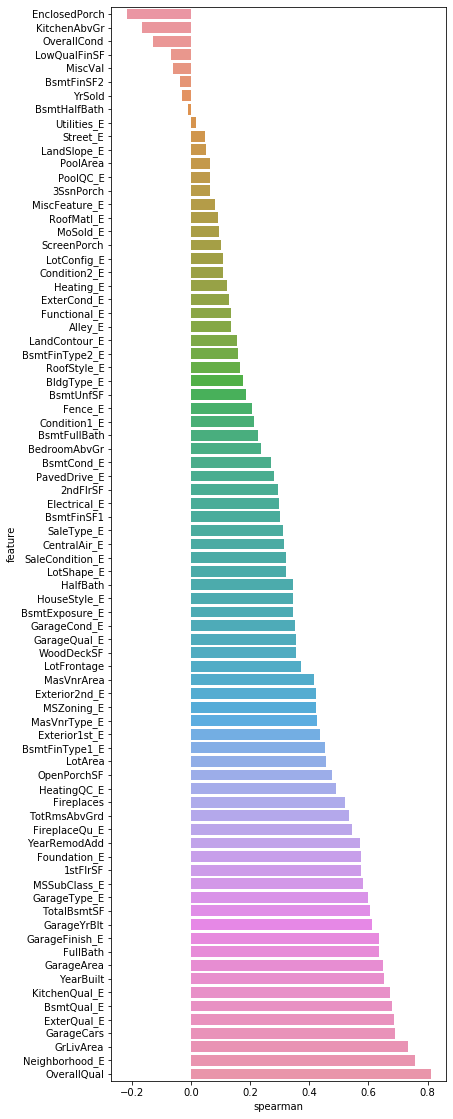

In [24]:
# Make a bar graph of the Spearman correlation coefficient of each qualitative encoded
# variable with SalePrice.

# YrSold correlates negatively with SalePrice because the data includes GFC.

def spearman(frame, target_col):
    features = quantitativeVariables(frame, 'Id', target_col)
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target_col], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

spearman(trainWithQualE, 'SalePrice')

Notable Correlations:
OverallQual ,  SalePrice ,  0.7957742674249441
YearBuilt ,  GarageYrBlt ,  0.8448398583188299
TotalBsmtSF ,  1stFlrSF ,  0.8038296279256137
GrLivArea ,  TotRmsAbvGrd ,  0.8294981976715387
GrLivArea ,  SalePrice ,  0.7349681645359343
GarageCars ,  GarageArea ,  0.8873044983919205


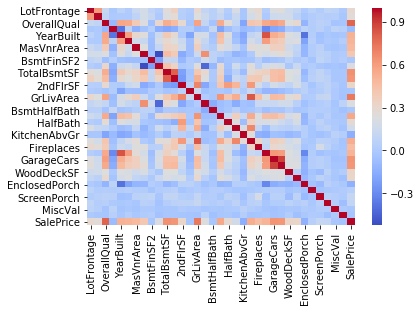

In [25]:
# Make heatmaps of Pearson correlation coefficient of quantitative variables plus SalePrice versus themselves

def varPearsonCorrHeatMap(frame, variables, threshold): 
    corr = frame[variables].corr()
    sns.heatmap(corr, cmap="coolwarm")

    print('Notable Correlations:')
    for i in range(len(variables)):
        for j in range(i+1, len(variables)):
            if corr.iloc[i][j] > threshold:
                print(variables[i], ", ", variables[j], ", ", corr.iloc[i][j])

variables = quantitativeVariables(train, 'Id', 'SalePrice') + ['SalePrice']
varPearsonCorrHeatMap(train, variables, 0.7)

Notable Correlations:
Exterior1st_E ,  Exterior2nd_E ,  0.902120906779063
ExterQual_E ,  KitchenQual_E ,  0.7138116830943017
GarageQual_E ,  GarageCond_E ,  0.8985654680192376


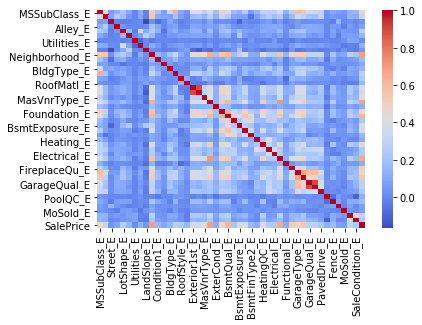

In [26]:
# Make heatmaps of Pearson correlation coefficient of qualitative variables plus SalePrice versus themselves

variables = [f+'_E' for f in qualitativeVariables(train)] + ['SalePrice']
varPearsonCorrHeatMap(trainWithQualE, variables, 0.7)

Notable Correlations
OverallQual ,  ExterQual_E ,  0.7232863886198884
OverallQual ,  SalePrice ,  0.7957742674249434
YearBuilt ,  Foundation_E ,  0.7264955503483206
GrLivArea ,  SalePrice ,  0.7349681645359327
Fireplaces ,  FireplaceQu_E ,  0.8134354206040728
PoolArea ,  PoolQC_E ,  0.9043058116008852


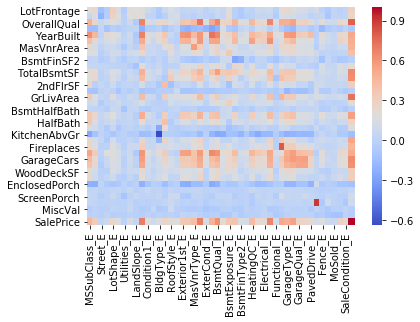

In [27]:
# Make heatmaps of Pearson correlation coefficients of quantitative variables plus SalePrice versus 
# qualitative variables plus SalePrice

def xyVarPearsonCorrHeatMap(frame, xVariables, yVariables, threshold):
    corr=pd.DataFrame(
        np.zeros([len(xVariables), len(yVariables)]),
        index=xVariables,
        columns=yVariables
    )

    print('Notable Correlations')
    for q1 in xVariables:
        for q2 in yVariables:
            corr.loc[q1,q2] = frame[q1].corr(frame[q2])
            if corr.loc[q1,q2] > threshold and q1 != q2:
                print(q1, ", ", q2, ", ", corr.loc[q1][q2])
    sns.heatmap(corr, cmap="coolwarm")
    
xVariables = quantitativeVariables(train, 'Id', 'SalePrice') + ['SalePrice']
yVariables = [f+'_E' for f in qualitativeVariables(train)] + ['SalePrice']
xyVarPearsonCorrHeatMap(trainWithQualE, xVariables, yVariables, 0.7)

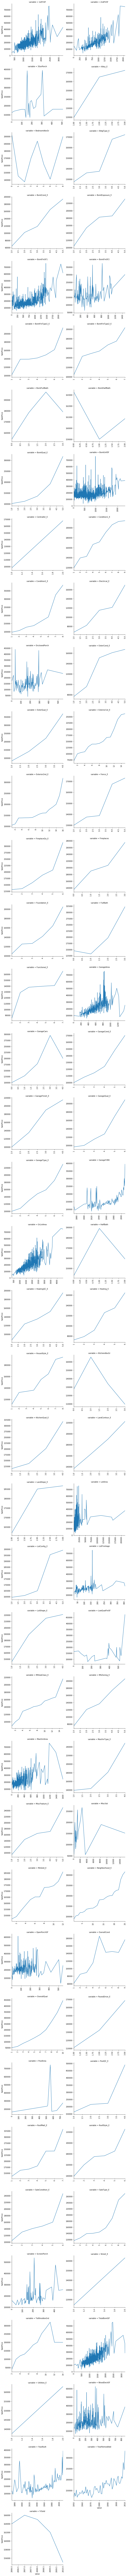

In [28]:
# Plot all quantitative and qualitative encoded features against SalePrice

def pairplot(x,y,**kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time':x, 'val':y})
    ts = ts.groupby('time').median()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)

def pairPlotFeaturesTarget(frame, target_col):
    features = quantitativeVariables(frame, 'Id', target_col)
    f = pd.melt(frame, id_vars=[target_col], value_vars=features)
    f = f.sort_values('variable')
    g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, height=5)
    g = g.map(pairplot, "value", target_col)
    
pairPlotFeaturesTarget(trainWithQualE, 'SalePrice')    

In [29]:
# We want to take features which are highly correlated with SalePrice. However, if a feature is highly 
# correlated with a previously chosen feature (that has a higher correlation with SalePrice), we should
# not choose it.

def featureSelection(frame, target_col, spThreshold, corrThreshold):
    features = quantitativeVariables(frame, 'Id', target_col) + [target_col]
    corr = frame[features].corr()
    corrWSP = corr['SalePrice']
    corrWSP = corrWSP.sort_values(ascending=False)
    corrWSP = corrWSP[abs(corrWSP) > spThreshold]
    sortedFeatures = corrWSP.index[1:] # remove SalePrice
    featureSelection = []
    featureSelection.append(sortedFeatures[0]) # loop won't work for first feature
    for i in range(len(sortedFeatures)):
        for j in range(i):
            if corr.loc[sortedFeatures[i]][sortedFeatures[j]] > corrThreshold:
                break
            if j == i-1:
                featureSelection.append(sortedFeatures[i])
    return featureSelection

featureSelection = featureSelection(trainWithQualE, 'SalePrice', 0.2, 0.7)
print(featureSelection)

['OverallQual', 'GrLivArea', 'Neighborhood_E', 'TotalBsmtSF', 'GarageCars', 'BsmtQual_E', 'FullBath', 'GarageFinish_E', 'FireplaceQu_E', 'YearBuilt', 'YearRemodAdd', 'GarageType_E', 'MasVnrArea', 'MSSubClass_E', 'HeatingQC_E', 'MasVnrType_E', 'BsmtFinSF1', 'BsmtFinType1_E', 'BsmtExposure_E', 'Exterior1st_E', 'WoodDeckSF', 'MSZoning_E', 'OpenPorchSF', '2ndFlrSF', 'SaleType_E', 'LotFrontage', 'HalfBath', 'GarageCond_E', 'HouseStyle_E', 'LotArea', 'LotShape_E', 'CentralAir_E', 'SaleCondition_E', 'RoofStyle_E', 'Electrical_E', 'PavedDrive_E', 'BsmtFullBath', 'BsmtCond_E', 'BsmtUnfSF']


In [30]:
# Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the 
# predicted value and the logarithm of the observed sales price. (Taking logs means that 
# errors in predicting expensive houses and cheap houses will affect the result equally.)

def rmse(predictions, targets):
    predictions = np.log(predictions)
    targets = np.log(targets)
    return np.sqrt(((predictions - targets) ** 2).mean())

In [31]:
# Simple 75-25 train test split with the features we selected standard scaled
# Check the ranks of the matrices we will pass into the linear regression

def checkRanksofFeatureMatrices(frame, features, target_values):
    scaler = StandardScaler()
    X_new = scaler.fit_transform(frame[features].values)
    X_train, X_test, y_train, y_test = train_test_split(X_new, target_values)
    print(X_train.shape)
    print(np.linalg.matrix_rank(X_train))
    print(X_test.shape)
    print(np.linalg.matrix_rank(X_test))
    return X_train, X_test, y_train, y_test

X_train1, X_test1, y_train1, y_test1 = checkRanksofFeatureMatrices(
    trainWithQualE, featureSelection, trainWithQualE['SalePrice'].values)

(1093, 39)
39
(365, 39)
39


In [32]:
# Plot the coefficients of a linear model

def plotCoeffs(features, coefficients):
    
    coeffs = pd.DataFrame()
    coeffs['features'] = features
    coeffs['coefficients'] = coefficients
    coeffs = coeffs.sort_values('coefficients', ascending=False)
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=coeffs, y='features', x='coefficients', orient='h')
    print(coeffs)

           features  coefficients
1         GrLivArea      0.130739
0       OverallQual      0.096840
3       TotalBsmtSF      0.038880
2    Neighborhood_E      0.038059
10     YearRemodAdd      0.034298
21       MSZoning_E      0.030201
32  SaleCondition_E      0.028046
4        GarageCars      0.026939
16       BsmtFinSF1      0.025897
31     CentralAir_E      0.024047
13     MSSubClass_E      0.016523
8     FireplaceQu_E      0.014203
29          LotArea      0.013814
14      HeatingQC_E      0.013303
25      LotFrontage      0.012478
18   BsmtExposure_E      0.012184
20       WoodDeckSF      0.011540
33      RoofStyle_E      0.010150
36     BsmtFullBath      0.009799
35     PavedDrive_E      0.009534
37       BsmtCond_E      0.009380
27     GarageCond_E      0.008985
19    Exterior1st_E      0.008835
7    GarageFinish_E      0.008292
22      OpenPorchSF      0.006878
12       MasVnrArea      0.006758
30       LotShape_E      0.006428
24       SaleType_E      0.006058
6          Ful

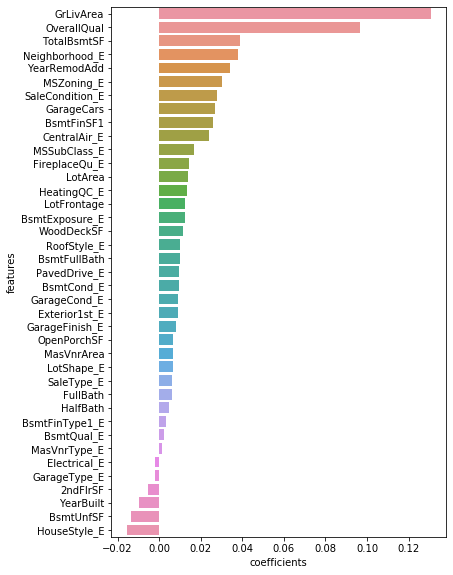

In [33]:
# You have to log transform your target variables. This is because we take RMSE on the logs of the 
# predicted prices, so we can never predict a negative price. We get around this issue by fitting
# a model on the log of SalePrice, which can be negative. However, e^(anything) is always positive
# so we get a positive SalePrice to plug into RMSE.

def OLS(X_train, X_test, y_train, y_test, features):
    reg = linear_model.LinearRegression().fit(X_train, np.log(y_train))
    
    plotCoeffs(features, reg.coef_)
    
    y_train_pred = reg.predict(X_train)
    print("Train Error: ", rmse(np.exp(y_train_pred), y_train))
    y_test_pred = reg.predict(X_test)
    print("Test Error: ", rmse(np.exp(y_test_pred), y_test))
    
OLS(X_train1, X_test1, y_train1, y_test1, featureSelection)    

In [34]:
# Let's keep going with standard scaling, but let's now try adding quadratic factors

def addQuadraticFeatures(frame, QuadFeatures):
    for f in QuadFeatures:
        frame.loc[:,f + "_Squared"] = frame.loc[:,f].apply(np.square)
    return frame
    
QuadFeatures = ['OverallQual', 'Neighborhood_E', 'GarageCars', 'FullBath', 'FireplaceQu_E', 
                'YearBuilt', 'YearRemodAdd'] 
trainWithQuad = trainWithQualE.copy()
trainWithQuad = addQuadraticFeatures(trainWithQuad, QuadFeatures)
trainWithQuad.head()

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1       SC60       RL         65.0     8450   Pave    NA      Reg   
1   2       SC20       RL         80.0     9600   Pave    NA      Reg   
2   3       SC60       RL         68.0    11250   Pave    NA      IR1   
3   4       SC70       RL         60.0     9550   Pave    NA      IR1   
4   5       SC60       RL         84.0    14260   Pave    NA      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating  ... BldgType_E HouseStyle_E RoofStyle_E  RoofMatl_E  Exterior1st_E  \
0    GasA  ...          4            7           2           2             12   
1    GasA  ...          4            5           2           2              7   
2    GasA  ...          4            7           2           2             12   
3    GasA  ...          4            7           2           2              6   
4    GasA  ...          4            7           2           2             12   

   Exterior2nd_E  MasVnrType_E  ExterQual_E  ExterCond_E  Foundation_E  \
0             14             3            3            5             6   
1              5             2            2            5             4   
2             14             3            3            5             6   
3              4             2            2            5             2   
4             14             3            3            5             6   

   BsmtQual_E  BsmtCond_E  BsmtExposure_E BsmtFinType1_E  BsmtFinType2_E  \
0           4           4               2              7               5   
1           4           4               5              5               5   
2           4           4               3              7               5   
3           3           5               2              5               5 

In [35]:
# Check the ranks of the feature matrices for the new test-train splits

SelectedPlusQuadFeatures = featureSelection + [f + "_Squared" for f in QuadFeatures]
X_train2, X_test2, y_train2, y_test2 = checkRanksofFeatureMatrices(
    trainWithQuad, SelectedPlusQuadFeatures, trainWithQuad['SalePrice'].values)

(1093, 46)
46
(365, 46)
46


                  features  coefficients
45    YearRemodAdd_Squared      3.226752
9                YearBuilt      1.415756
1                GrLivArea      0.123982
0              OverallQual      0.070380
2           Neighborhood_E      0.048010
43   FireplaceQu_E_Squared      0.042485
3              TotalBsmtSF      0.041882
41      GarageCars_Squared      0.033269
21              MSZoning_E      0.029062
16              BsmtFinSF1      0.027034
31            CentralAir_E      0.026959
32         SaleCondition_E      0.024534
13            MSSubClass_E      0.022863
27            GarageCond_E      0.021449
6                 FullBath      0.019218
39     OverallQual_Squared      0.018761
14             HeatingQC_E      0.017469
18          BsmtExposure_E      0.016912
29                 LotArea      0.016821
19           Exterior1st_E      0.015375
26                HalfBath      0.014024
36            BsmtFullBath      0.011245
20              WoodDeckSF      0.010577
22             O

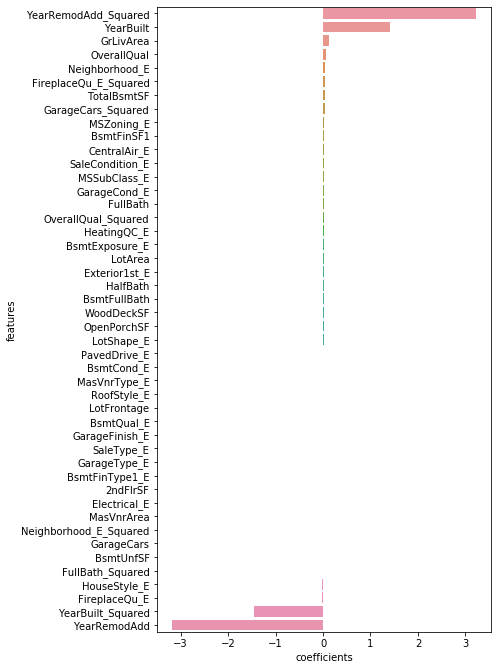

In [36]:
# Quadratic Features seem to help

OLS(X_train2, X_test2, y_train2, y_test2, SelectedPlusQuadFeatures)

In [37]:
# You can't send all the quantitative and qualitative variables into ordinary linear regression because the 
# feature matrix doesn't have full rank.

quantandqualE = quantitativeVariables(trainWithQualE, 'Id', 'SalePrice')
X_train3, X_test3, y_train3, y_test3 = checkRanksofFeatureMatrices(
    trainWithQualE, quantandqualE, trainWithQualE['SalePrice'].values)

(1093, 79)
77
(365, 79)
77


           features  coefficients
14        GrLivArea  1.218448e+11
9         BsmtUnfSF  2.745270e+10
7        BsmtFinSF1  2.688649e+10
8        BsmtFinSF2  1.002389e+10
2       OverallQual  6.914501e-02
3       OverallCond  4.320853e-02
43   Neighborhood_E  4.191613e-02
24       GarageCars  2.257681e-02
35       MSZoning_E  2.224874e-02
78  SaleCondition_E  2.131200e-02
50    Exterior1st_E  2.071810e-02
21     TotRmsAbvGrd  2.025259e-02
66     Functional_E  1.960301e-02
30      ScreenPorch  1.926017e-02
34     MSSubClass_E  1.752377e-02
4         YearBuilt  1.692291e-02
1           LotArea  1.683465e-02
15     BsmtFullBath  1.533413e-02
65    KitchenQual_E  1.528072e-02
55     Foundation_E  1.520586e-02
62      HeatingQC_E  1.394808e-02
67    FireplaceQu_E  1.260233e-02
5      YearRemodAdd  1.252657e-02
71     GarageCond_E  1.250219e-02
63     CentralAir_E  1.236773e-02
31         PoolArea  1.184428e-02
25       GarageArea  1.173496e-02
58   BsmtExposure_E  1.016665e-02
44     Conditi

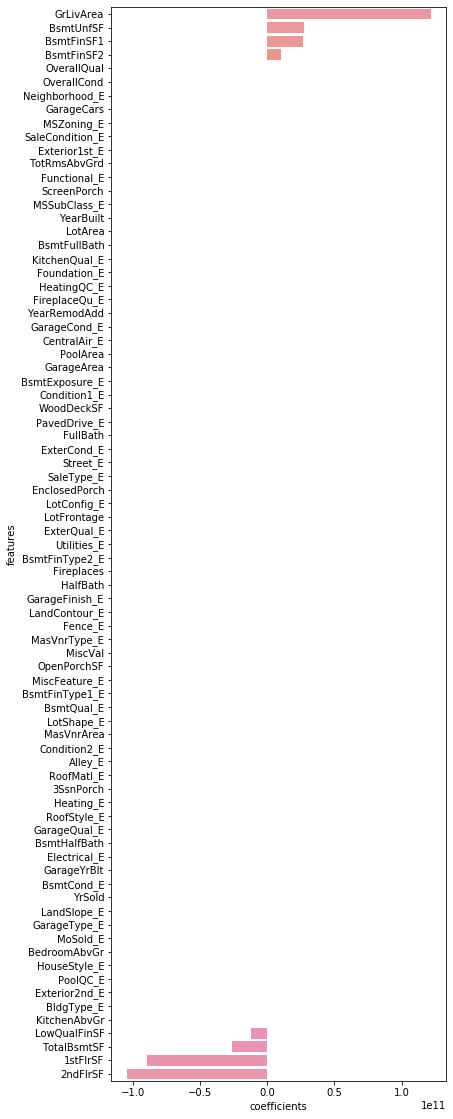

In [38]:
# Some of the coefficients got really big while some of the coefficients shrank to nothing. 
# Compare to linear regression with a full rank matrix, where the coefficients have the same
# order of magnitude.

OLS(X_train3, X_test3, y_train3, y_test3, quantandqualE)

In [39]:
# Plot average RMSE across each of the test folds as alpha varies. Necessary for Lasso, Ridge, and ElasticNet 
# as they have alphas that need to be tuned

def plotRMSEVersusAlpha(alphas, best_alpha, mse_path, axis):
    plt.plot(
        alphas, 
        np.sqrt(mse_path).mean(axis=axis),
        color="black",
        label = "Avg across the folds",
        linewidth = 2
    )
    
    plt.axvline(best_alpha, linestyle = "--", color="black", label="alpha CV est")

    plt.xlabel(r"$\alpha$")
    plt.ylabel("RMSE")
    plt.legend()
    plt.title("RMSE Versus Alpha")

           features  coefficients
14        GrLivArea      0.126134
2       OverallQual      0.076401
43   Neighborhood_E      0.040777
3       OverallCond      0.039248
10      TotalBsmtSF      0.033230
7        BsmtFinSF1      0.030855
35       MSZoning_E      0.025234
78  SaleCondition_E      0.022525
24       GarageCars      0.022312
4         YearBuilt      0.018518
66     Functional_E      0.015958
65    KitchenQual_E      0.014831
1           LotArea      0.014322
25       GarageArea      0.013220
62      HeatingQC_E      0.013175
63     CentralAir_E      0.013168
11         1stFlrSF      0.012815
58   BsmtExposure_E      0.012083
5      YearRemodAdd      0.011170
30      ScreenPorch      0.010886
67    FireplaceQu_E      0.010224
15     BsmtFullBath      0.009773
34     MSSubClass_E      0.007891
44     Condition1_E      0.007731
55     Foundation_E      0.007226
53      ExterQual_E      0.007029
22       Fireplaces      0.006750
26       WoodDeckSF      0.006616
36         Str

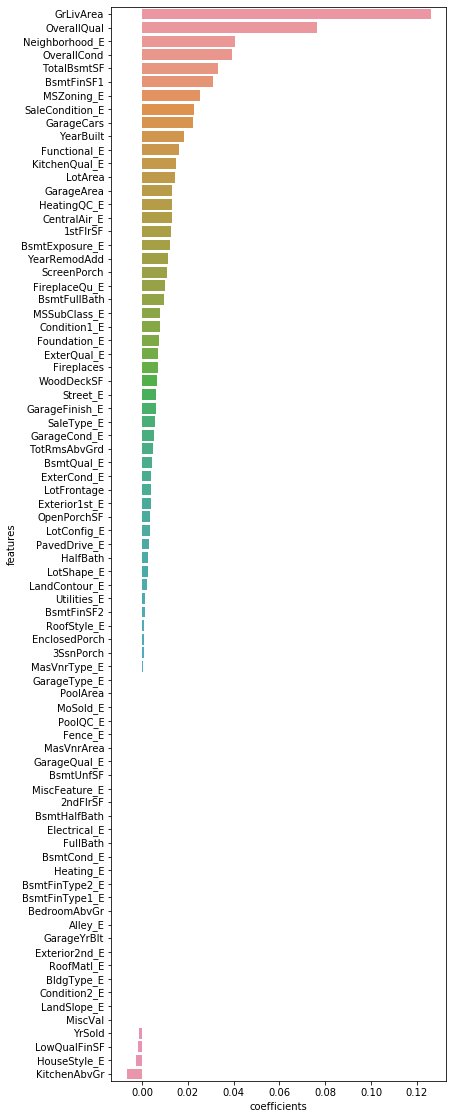

In [63]:
# Fit Lasso with cross-validation to tune alpha.  Notice how the coefficients of Lasso are very 
# similar to your featureSelection using Pearson correlation coefficient.

from sklearn.linear_model import LassoCV

def LassoCVwithStandardScaling(frame, features, target_values, alphas):
    scaler = StandardScaler()
    X_new = scaler.fit_transform(frame[features].values)
    lasso = LassoCV(cv=5, alphas=alphas, max_iter=10000).fit(X_new, np.log(target_values))
    plotCoeffs(features, lasso.coef_)    
    return lasso

alphas = np.linspace(0.0001, 0.005, num=100)
lasso = LassoCVwithStandardScaling(trainWithQualE, quantandqualE, trainWithQualE['SalePrice'].values, alphas)

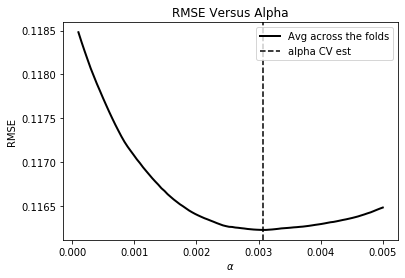

In [41]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lasso.alphas_, lasso.alpha_, lasso.mse_path_, -1)

           features  coefficients
2       OverallQual      0.063444
14        GrLivArea      0.061948
11         1stFlrSF      0.044365
3       OverallCond      0.040060
43   Neighborhood_E      0.038882
12         2ndFlrSF      0.034329
10      TotalBsmtSF      0.030545
7        BsmtFinSF1      0.028977
35       MSZoning_E      0.024504
78  SaleCondition_E      0.022326
24       GarageCars      0.018911
66     Functional_E      0.017892
21     TotRmsAbvGrd      0.017821
25       GarageArea      0.017692
65    KitchenQual_E      0.015723
1           LotArea      0.014693
34     MSSubClass_E      0.014201
62      HeatingQC_E      0.013927
5      YearRemodAdd      0.013786
30      ScreenPorch      0.013564
63     CentralAir_E      0.013462
58   BsmtExposure_E      0.012391
4         YearBuilt      0.012272
15     BsmtFullBath      0.011676
67    FireplaceQu_E      0.011228
53      ExterQual_E      0.010996
50    Exterior1st_E      0.010820
17         FullBath      0.010453
36         Str

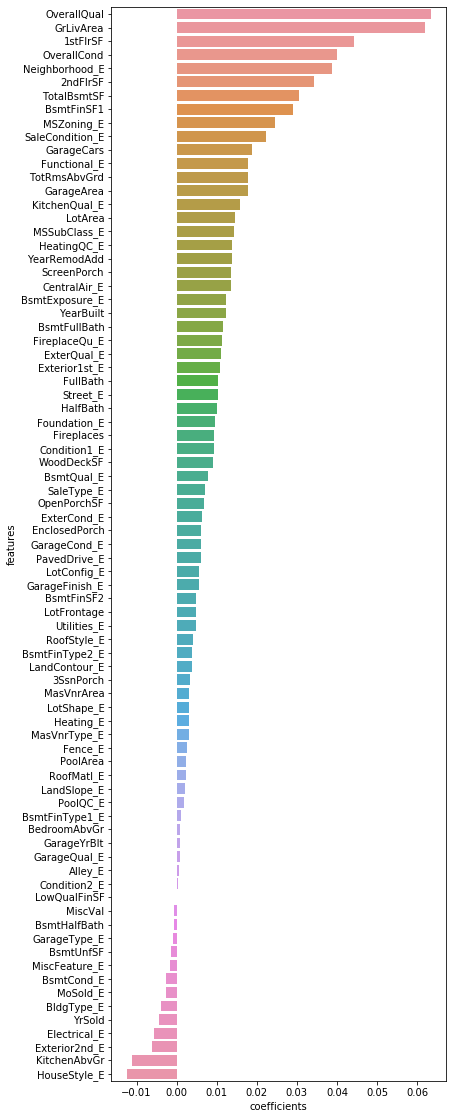

In [42]:
# Fit Ridge with cross-validation to tune alpha.

from sklearn.linear_model import RidgeCV

def RidgeCVwithStandardScaling(frame, features, target_values, alphas):
    scaler = StandardScaler()
    X_new = scaler.fit_transform(frame[features].values)
    ridge = RidgeCV(alphas = alphas, store_cv_values=True).fit(X_new, np.log(target_values))
    plotCoeffs(features, ridge.coef_)    
    return ridge

alphas = np.linspace(85, 95, 100)
ridge = RidgeCVwithStandardScaling(trainWithQualE, quantandqualE, trainWithQualE['SalePrice'].values, alphas)

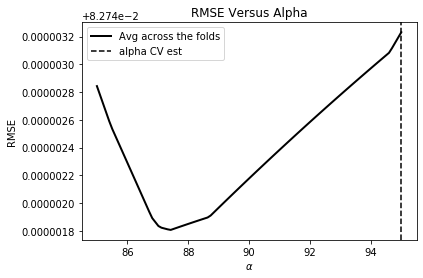

In [43]:
plotRMSEVersusAlpha(alphas, ridge.alpha_, ridge.cv_values_, 0)

In [44]:
# Fit ElasticNet with cross-validation to tune alpha.

from sklearn.linear_model import ElasticNetCV

def ElasticNetCVwithStandardScaling(frame, features, target_values, alphas, l1_ratio):
    scaler = StandardScaler()
    X_new = scaler.fit_transform(frame[features].values)
    ENet = ElasticNetCV(l1_ratio = l1_ratio, alphas = alphas, cv=5).fit(X_new, np.log(target_values))
    plotCoeffs(features, ENet.coef_)    
    return ENet

           features  coefficients
2       OverallQual      0.061299
14        GrLivArea      0.059595
11         1stFlrSF      0.042919
3       OverallCond      0.038898
43   Neighborhood_E      0.038292
12         2ndFlrSF      0.032733
10      TotalBsmtSF      0.030422
7        BsmtFinSF1      0.028725
35       MSZoning_E      0.024014
78  SaleCondition_E      0.021855
21     TotRmsAbvGrd      0.019030
24       GarageCars      0.018640
25       GarageArea      0.018069
66     Functional_E      0.017438
65    KitchenQual_E      0.016362
1           LotArea      0.014455
5      YearRemodAdd      0.014067
62      HeatingQC_E      0.014027
34     MSSubClass_E      0.013768
63     CentralAir_E      0.013392
30      ScreenPorch      0.013349
58   BsmtExposure_E      0.012381
53      ExterQual_E      0.011894
15     BsmtFullBath      0.011734
67    FireplaceQu_E      0.011643
17         FullBath      0.011499
4         YearBuilt      0.010803
18         HalfBath      0.010544
36         Str

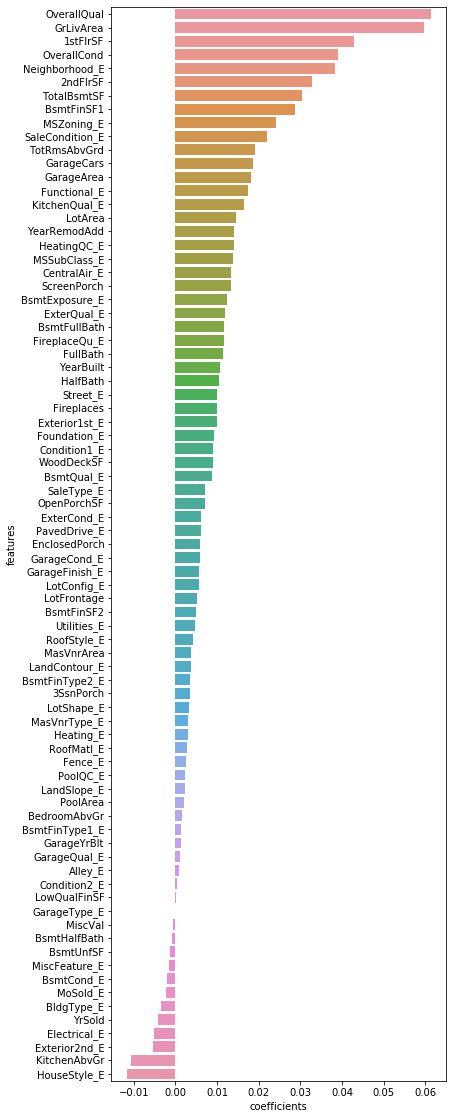

In [45]:
# ElasticNet with l1 ratio biased towards Ridge

alphas = np.linspace(0.01, 0.1, 100)
ENetRidge = ElasticNetCVwithStandardScaling(
    trainWithQualE, 
    quantandqualE, 
    trainWithQualE['SalePrice'].values, 
    alphas,
    0.0001)

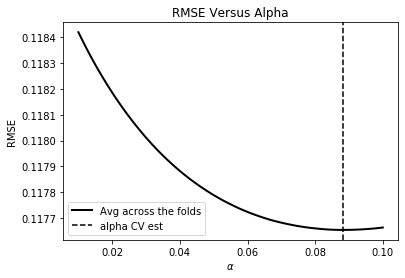

In [46]:
plotRMSEVersusAlpha(ENetRidge.alphas_, ENetRidge.alpha_, ENetRidge.mse_path_, -1)

           features  coefficients
14        GrLivArea      0.126134
2       OverallQual      0.076401
43   Neighborhood_E      0.040777
3       OverallCond      0.039249
10      TotalBsmtSF      0.033230
7        BsmtFinSF1      0.030856
35       MSZoning_E      0.025234
78  SaleCondition_E      0.022525
24       GarageCars      0.022312
4         YearBuilt      0.018519
66     Functional_E      0.015958
65    KitchenQual_E      0.014830
1           LotArea      0.014322
25       GarageArea      0.013220
62      HeatingQC_E      0.013175
63     CentralAir_E      0.013168
11         1stFlrSF      0.012815
58   BsmtExposure_E      0.012083
5      YearRemodAdd      0.011170
30      ScreenPorch      0.010886
67    FireplaceQu_E      0.010224
15     BsmtFullBath      0.009773
34     MSSubClass_E      0.007891
44     Condition1_E      0.007731
55     Foundation_E      0.007226
53      ExterQual_E      0.007029
22       Fireplaces      0.006750
26       WoodDeckSF      0.006617
36         Str

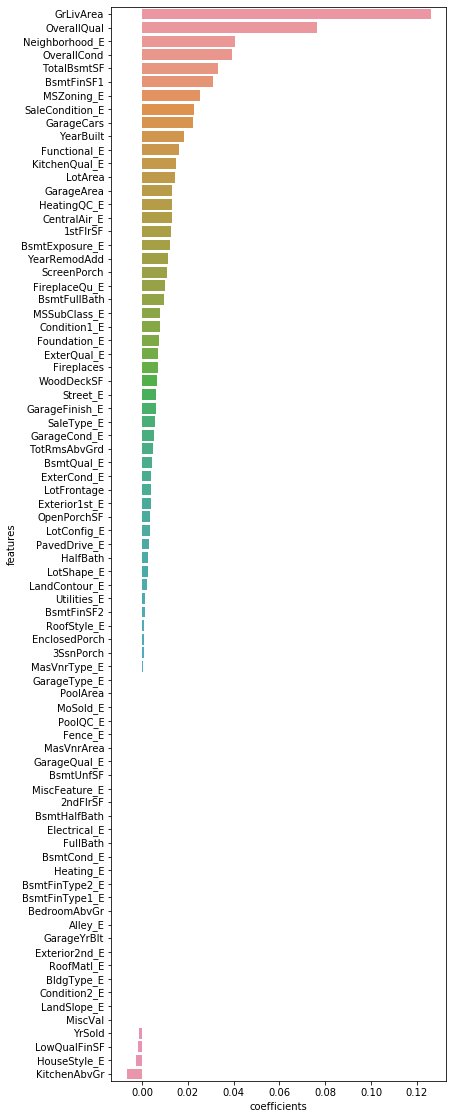

In [47]:
# ElasticNet with l1 ratio biased towards Lasso

alphas = np.linspace(0.0001, 0.005, num=100)
ENetLasso = ElasticNetCVwithStandardScaling(
    trainWithQualE, 
    quantandqualE, 
    trainWithQualE['SalePrice'].values, 
    alphas,
    0.9999)

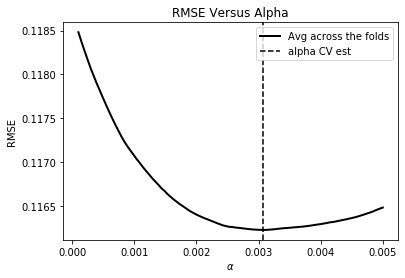

In [48]:
plotRMSEVersusAlpha(ENetLasso.alphas_, ENetLasso.alpha_, ENetLasso.mse_path_, -1)

           features  coefficients
14        GrLivArea      0.123620
2       OverallQual      0.076005
43   Neighborhood_E      0.040795
3       OverallCond      0.039124
10      TotalBsmtSF      0.032689
7        BsmtFinSF1      0.030831
35       MSZoning_E      0.025072
78  SaleCondition_E      0.022467
24       GarageCars      0.022039
4         YearBuilt      0.017790
66     Functional_E      0.015968
65    KitchenQual_E      0.014898
1           LotArea      0.014378
11         1stFlrSF      0.013817
25       GarageArea      0.013597
62      HeatingQC_E      0.013305
63     CentralAir_E      0.013141
58   BsmtExposure_E      0.012098
5      YearRemodAdd      0.011224
30      ScreenPorch      0.010958
67    FireplaceQu_E      0.010233
15     BsmtFullBath      0.009791
34     MSSubClass_E      0.008104
44     Condition1_E      0.007732
55     Foundation_E      0.007388
53      ExterQual_E      0.007287
22       Fireplaces      0.006937
26       WoodDeckSF      0.006708
36         Str

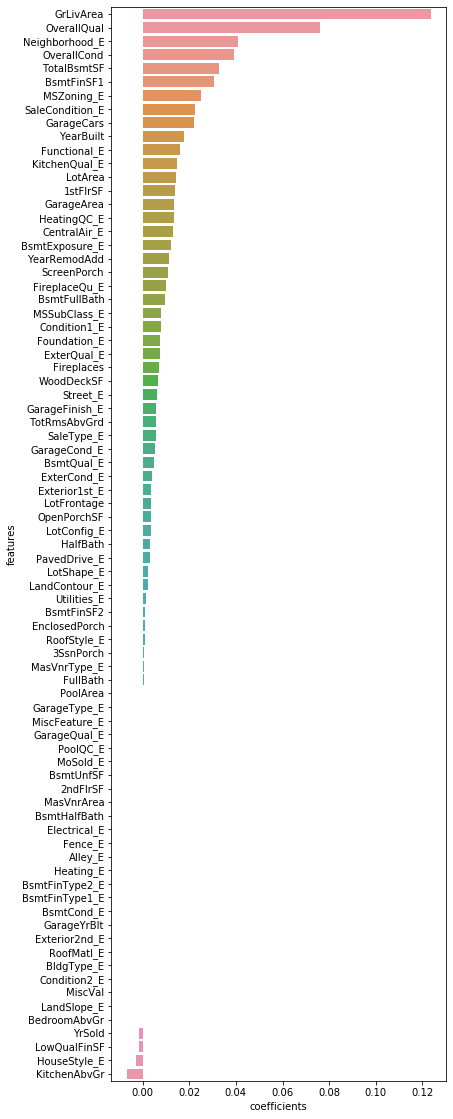

In [49]:
# ElasticNet with l1 ratio biased towards Lasso

alphas = np.linspace(0.0001, 0.01, num=100)
ENetBalanced = ElasticNetCVwithStandardScaling(
    trainWithQualE, 
    quantandqualE, 
    trainWithQualE['SalePrice'].values, 
    alphas,
    0.5)

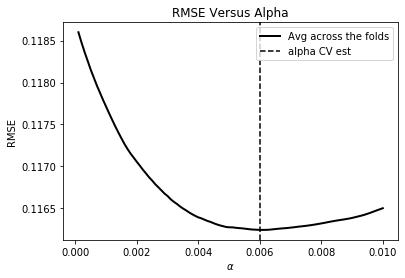

In [50]:
plotRMSEVersusAlpha(ENetBalanced.alphas_, ENetBalanced.alpha_, ENetBalanced.mse_path_, -1)

In [51]:
test = pd.read_csv('./test.csv')

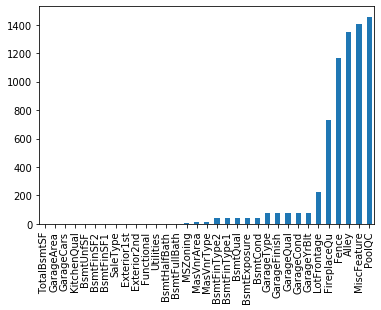

In [52]:
# Check if test set has missing features

missingTest = missingCheck(test)

In [53]:
# Find the missing features that are qualitative
MissingTestQualColumns = set(missingTest.index.to_list()) & set(qualitativeVariables(test))
print(MissingTestQualColumns)

{'MSZoning', 'PoolQC', 'Fence', 'Exterior2nd', 'GarageType', 'FireplaceQu', 'Functional', 'GarageFinish', 'GarageQual', 'BsmtFinType2', 'MasVnrType', 'BsmtExposure', 'BsmtQual', 'MiscFeature', 'KitchenQual', 'Exterior1st', 'Alley', 'BsmtFinType1', 'SaleType', 'Utilities', 'GarageCond', 'BsmtCond'}


In [54]:
# Find the cols where NA is being misread as null and explicitly fill in NA.

TestNACols = MissingTestQualColumns
TestNACols.remove('Functional')
TestNACols.remove('Utilities')
TestNACols.remove('KitchenQual')
TestNACols.remove('Exterior1st')
TestNACols.remove('Exterior2nd')
TestNACols.remove('MasVnrType')
TestNACols.remove('MSZoning')
TestNACols.remove('SaleType')
for f in TestNACols:
    test[f] = test[f].fillna('NA')
    print(f, test[f].isnull().sum())

PoolQC 0
Fence 0
GarageType 0
FireplaceQu 0
GarageFinish 0
GarageQual 0
BsmtFinType2 0
BsmtExposure 0
BsmtQual 0
MiscFeature 0
Alley 0
BsmtFinType1 0
GarageCond 0
BsmtCond 0


In [55]:
# Fill in LotFrontage with the square root of LotArea
sqrtLotArea = np.floor(test['LotArea']**(1/2))
test['LotFrontage'] = test['LotFrontage'].fillna(sqrtLotArea)

In [56]:
# Fill in missing values of GarageYrBlt with YearBuilt as these are highly correlated

test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['YearBuilt'])

{'Utilities', 'MSZoning', 'Exterior2nd', 'MasVnrType', 'KitchenQual', 'Exterior1st', 'Functional', 'SaleType'}
{'GarageCars', 'BsmtUnfSF', 'BsmtFinSF2', 'GarageArea', 'MasVnrArea', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1'}


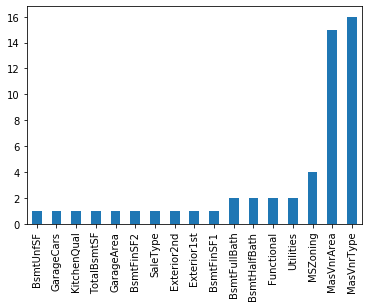

In [57]:
missingTest = missingCheck(test)
missingQualitative = set(missingTest.index.to_list()) & set(qualitativeVariables(test))
print(missingQualitative)
missingQuantitative = set(missingTest.index.to_list()) & set(quantitativeVariables(train, 'Id', 'SalePrice'))
print(missingQuantitative)

In [58]:
# Fill in the missing qualitative variables with the most common value
for f in missingQualitative:
    test[f] = test[f].fillna(qualMostCommonDict[f])
    print(f, test[f].isnull().sum())

Utilities 0
MSZoning 0
Exterior2nd 0
MasVnrType 0
KitchenQual 0
Exterior1st 0
Functional 0
SaleType 0


In [59]:
# Fill in missing quantitative variables with the median
for f in missingQuantitative:
    test[f] = test[f].fillna(quantMedianDict[f])
    print(f, test[f].isnull().sum())

GarageCars 0
BsmtUnfSF 0
BsmtFinSF2 0
GarageArea 0
MasVnrArea 0
TotalBsmtSF 0
BsmtFullBath 0
BsmtHalfBath 0
BsmtFinSF1 0


In [60]:
# No more missing data in test!

test[test.isnull().any(axis=1)]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition]
Index: []

In [71]:
# Make the same transformations to test

test = quantToQual(test)
testWithQualE = test.copy()
featureOrdering['MSSubClass']['SC150'] = 16
testWithQualE = qualitativeEncode(testWithQualE)
testWithQualE.head()

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461       SC20       RH         80.0    11622   Pave    NA      Reg   
1  1462       SC20       RL         81.0    14267   Pave    NA      IR1   
2  1463       SC60       RL         74.0    13830   Pave    NA      IR1   
3  1464       SC60       RL         78.0     9978   Pave    NA      IR1   
4  1465      SC120       RL         43.0     5005   Pave    NA      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
4         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   
2       Norm     1Fam     2Story            5            5       1997   
3       Norm     1Fam     2Story            6            6       1998   
4       Norm   TwnhsE     1Story            8            5       1992   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd       None   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2          1998     Gable  CompShg     VinylSd     VinylSd       None   
3          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4          1992     Gable  CompShg     HdBoard     HdBoard       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   
2         0.0        TA        TA      PConc       Gd       TA           No   
3        20.0        TA        TA      PConc       TA       TA           No   
4         0.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   
2          GLQ       791.0          Unf         0.0      137.0        928.0   
3          GLQ       602.0          Unf         0.0      324.0        926.0   
4          ALQ       263.0          Unf         0.0     1017.0       1280.0   

  Heating  ... LandContour_E Utilities_E LotConfig_E  LandSlope_E  \
0    GasA  ...             2           2           1            1   
1    GasA  ...             2           2           2            1   
2    GasA  ...             2           2           1            1   
3    GasA  ...             2           2           1            1   
4    GasA  ...             4           2           1            1   

   Neighborhood_E  Condition1_E  Condition2_E  BldgType_E  HouseStyle_E  \
0              10             2             5           4             5   
1              10             4             5           4             5   
2              14             4             5           4             7   
3              14             4             5           4             7   
4              23             4             5           5             5   

   RoofStyle_E  RoofMatl_E  Exterior1st_E  Exterior2nd_E MasVnrType_E  \
0            2           2             12             14            2   
1            4           2              6              3            3   
2            2           2             12             14            2   
3            2           2             12             14            3   
4            2           2              9              9            

In [47]:
# Prepare to train on the entire training set

def checkRanksofFeatureMatricesNoSplit(frame, features):
    scaler = StandardScaler()
    X_new = scaler.fit_transform(frame[features].values)
    print(X_new.shape)
    print(np.linalg.matrix_rank(X_new))
    return X_new

X_train_Final = checkRanksofFeatureMatricesNoSplit(trainWithQuad, SelectedPlusQuadFeatures)

(1458, 46)
46


In [48]:
X_test_Final = checkRanksofFeatureMatricesNoSplit(testWithQuad, SelectedPlusQuadFeatures)

(1459, 46)
46


In [49]:
def OLSFinal(X_train, X_test, y_train):
    reg = linear_model.LinearRegression().fit(X_train, np.log(y_train))
    y_train_pred = reg.predict(X_train)
    print("Train Error: ", rmse(np.exp(y_train_pred), y_train))
    y_test_pred = reg.predict(X_test)
    return np.exp(y_test_pred)
    
y_test_pred = OLSFinal(X_train_Final, X_test_Final, trainWithQuad['SalePrice'].values)    

Train Error:  0.11811305226953293


In [50]:
test['SalePrice'] = y_test_pred
FirstSubmission = test[['Id', 'SalePrice']]
FirstSubmission.head()

Id      SalePrice
0  1461  115929.374336
1  1462  161061.131477
2  1463  180315.733077
3  1464  195187.731837
4  1465  194715.915737

In [77]:
FirstSubmissionCSV = FirstSubmission.to_csv('/home/seasnake/Desktop/Kaggle_Housing/sub1.csv', index=False)

In [73]:
def modelPredict(frame, features, model):
    scaler = StandardScaler()
    X_new = scaler.fit_transform(frame[features].values)
    y_pred = model.predict(X_new)
    return np.exp(y_pred)

In [97]:
testCompare = test.copy()
models = [lasso, ridge, ENetLasso, ENetRidge, ENetBalanced]
strmodels = ['lasso', 'ridge', 'ENetLasso', 'ENetRidge', 'ENetBalanced']
for i in range(len(models)):
    y_test_pred = modelPredict(testWithQualE, quantandqualE, models[i])
    testCompare[strmodels[i]] = y_test_pred
Comparison = testCompare[['Id'] + strmodels]
Comparison.head()

Id          lasso          ridge      ENetLasso      ENetRidge  \
0  1461  120254.480188  119334.914224  120254.386989  119494.364481   
1  1462  161252.765067  158011.473432  161252.799245  158203.256170   
2  1463  175718.562435  174573.782442  175718.443129  174798.143564   
3  1464  195817.358132  197777.607511  195817.431152  197881.457284   
4  1465  198813.868902  195169.132500  198813.736352  194594.566270   

    ENetBalanced  
0  120364.043139  
1  161363.491570  
2  175651.222919  
3  195830.309127  
4  198766.856948

In [83]:
for strmodel in strmodels:
    Submission = Comparison[['Id'] + [strmodel]]
    Submission = Submission.rename(columns={strmodel : 'SalePrice'})
    path = '/home/seasnake/Desktop/Kaggle_Housing/sub' + strmodel + '.csv'
    Submission.to_csv(path, index=False)

In [89]:
from sklearn.ensemble import RandomForestRegressor

def randomForest(frame, features, target_values):
    X_train, X_test, y_train, y_test = train_test_split(frame[features].values, target_values)
    regr_rf = RandomForestRegressor(n_estimators=100)
    regr_rf.fit(X_train, y_train)
    y_train_pred = regr_rf.predict(X_train)
    print("Train Error: ", rmse(y_train_pred, y_train))
    y_test_pred = regr_rf.predict(X_test)
    print("Test Error: ", rmse(y_test_pred, y_test))

In [90]:
randomForest(trainWithQualE, quantandqualE, trainWithQualE['SalePrice'].values) 

Train Error:  0.05358565311919458
Test Error:  0.1495414132297897


In [91]:
def randomForestFinal(trainFrame, features, target_values, testFrame):
    X_train = trainFrame[features].values
    regr_rf = RandomForestRegressor(n_estimators=100)
    regr_rf.fit(X_train, target_values)
    y_train_pred = regr_rf.predict(X_train)
    print("Train Error: ", rmse(y_train_pred, target_values))
    X_test = testFrame[features].values
    y_test_pred = regr_rf.predict(X_test)
    return y_test_pred

In [92]:
y_test_rf = randomForestFinal(trainWithQualE, quantandqualE, trainWithQualE['SalePrice'].values, testWithQualE)

Train Error:  0.05472637296205589


In [98]:
Comparison['random_forest'] = y_test_rf
Comparison.head()

/home/seasnake/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Id          lasso          ridge      ENetLasso      ENetRidge  \
0  1461  120254.480188  119334.914224  120254.386989  119494.364481   
1  1462  161252.765067  158011.473432  161252.799245  158203.256170   
2  1463  175718.562435  174573.782442  175718.443129  174798.143564   
3  1464  195817.358132  197777.607511  195817.431152  197881.457284   
4  1465  198813.868902  195169.132500  198813.736352  194594.566270   

    ENetBalanced  random_forest  
0  120364.043139      126459.58  
1  161363.491570      153333.50  
2  175651.222919      180952.51  
3  195830.309127      186435.86  
4  198766.856948      199479.02

In [99]:
Submission = Comparison[['Id'] + ['random_forest']]
Submission = Submission.rename(columns={'random_forest' : 'SalePrice'})
path = '/home/seasnake/Desktop/Kaggle_Housing/sub' + 'random_forest' + '.csv'
Submission.to_csv(path, index=False)

                  features  coefficients
14               GrLivArea      0.125558
2              OverallQual      0.043111
3              OverallCond      0.040879
43          Neighborhood_E      0.040275
79     OverallQual_Squared      0.034893
10             TotalBsmtSF      0.032705
7               BsmtFinSF1      0.030474
35              MSZoning_E      0.025606
78         SaleCondition_E      0.022527
84       YearBuilt_Squared      0.019385
81      GarageCars_Squared      0.017928
66            Functional_E      0.015562
1                  LotArea      0.014692
63            CentralAir_E      0.013796
65           KitchenQual_E      0.013563
62             HeatingQC_E      0.012952
11                1stFlrSF      0.012330
58          BsmtExposure_E      0.011606
25              GarageArea      0.011479
85    YearRemodAdd_Squared      0.011422
30             ScreenPorch      0.011229
15            BsmtFullBath      0.010333
83   FireplaceQu_E_Squared      0.010219
71            Ga

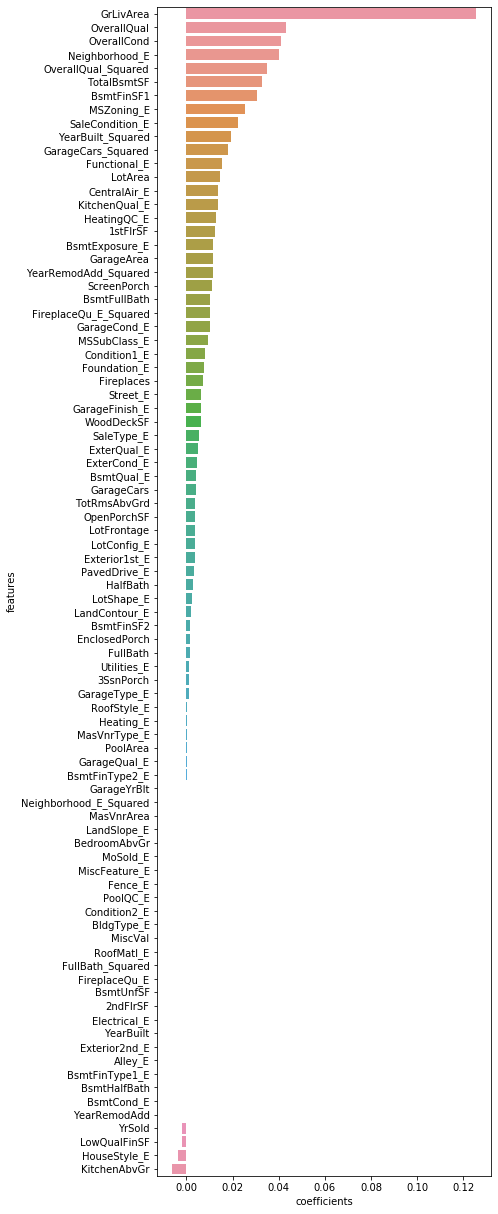

In [64]:
QuantAndQualEPlusQuadFeatures = quantandqualE + [f + "_Squared" for f in QuadFeatures]
alphasQuad = np.linspace(0.0001, 0.005, num=100)
lassoQuad = LassoCVwithStandardScaling(trainWithQuad, QuantAndQualEPlusQuadFeatures, trainWithQuad['SalePrice'].values, alphas)

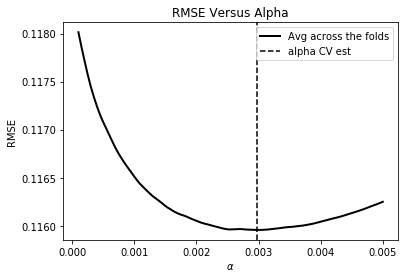

In [65]:
plotRMSEVersusAlpha(lassoQuad.alphas_, lassoQuad.alpha_, lassoQuad.mse_path_, -1)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

def myAdaBoost(X_train_scaled, y_train, X_test_scaled, y_test):
    regr = AdaBoostRegressor(random_state=0, n_estimators=100)
    regr.fit(X_train_scaled, np.log(y_train))
    y_train_pred = regr.predict(X_train_scaled)
    print("Train Error: ", rmse(np.exp(y_train_pred), y_train))
    y_test_pred = regr.predict(X_test_scaled)
    print("Test Error: ", rmse(np.exp(y_test_pred), y_test))
    return regr

In [ ]:
Ada1 = myAdaBoost(X_train1_scaled, y_train1, X_test1_scaled, y_test1)

In [ ]:
test_df_Ada = difficultExamples(X_test1, y_test1, Ada1, X_test1_scaled)
test_df_Ada.head()